In [67]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy

from tqdm import tqdm
from scipy.spatial import ConvexHull
from collections import defaultdict
from util import load_data, separate_data
from models.graphcnn import GraphCNN

In [79]:
def train(args, model, device, train_graphs, optimizer, epoch):
    model.train()

    total_iters = args['iters_per_epoch']

    loss_accum = 0
    for pos in range(total_iters):
        selected_idx = np.random.permutation(len(train_graphs))[:args['batch_size']]

        batch_graph = [train_graphs[idx] for idx in selected_idx]
        output = model(batch_graph)

        labels = torch.LongTensor([graph.label for graph in batch_graph]).to(device)

        #compute loss
        loss = criterion(output, labels)

        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()         
            optimizer.step()
        

        loss = loss.detach().cpu().numpy()
        loss_accum += loss

    average_loss = loss_accum/total_iters
    print("loss training: %f" % (average_loss))
    
    return average_loss

###pass data to model with minibatch during testing to avoid memory overflow (does not perform backpropagation)
def pass_data_iteratively(model, graphs, minibatch_size = 64):
    model.eval()
    output = []
    idx = np.arange(len(graphs))
    for i in range(0, len(graphs), minibatch_size):
        sampled_idx = idx[i:i+minibatch_size]
        if len(sampled_idx) == 0:
            continue
        output.append(model([graphs[j] for j in sampled_idx]).detach())
    return torch.cat(output, 0)

def test(args, model, device, train_graphs, test_graphs, epoch):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_train = correct / float(len(train_graphs))

    output = pass_data_iteratively(model, test_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in test_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_test = correct / float(len(test_graphs))

    print("accuracy train: %f test: %f" % (acc_train, acc_test))

    return acc_train, acc_test

In [3]:
class FeatsGraphCNN(GraphCNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __preprocess_neighbors_maxpool(self, batch_graph):
        ###create padded_neighbor_list in concatenated graph

        #compute the maximum number of neighbors within the graphs in the current minibatch
        max_deg = max([graph.max_neighbor for graph in batch_graph])

        padded_neighbor_list = []
        start_idx = [0]


        for i, graph in enumerate(batch_graph):
            start_idx.append(start_idx[i] + len(graph.g))
            padded_neighbors = []
            for j in range(len(graph.neighbors)):
                #add off-set values to the neighbor indices
                pad = [n + start_idx[i] for n in graph.neighbors[j]]
                #padding, dummy data is assumed to be stored in -1
                pad.extend([-1]*(max_deg - len(pad)))

                #Add center nodes in the maxpooling if learn_eps is False, i.e., aggregate center nodes and neighbor nodes altogether.
                if not self.learn_eps:
                    pad.append(j + start_idx[i])

                padded_neighbors.append(pad)
            padded_neighbor_list.extend(padded_neighbors)

        return torch.LongTensor(padded_neighbor_list)


    def __preprocess_neighbors_sumavepool(self, batch_graph):
        ###create block diagonal sparse matrix

        edge_mat_list = []
        start_idx = [0]
        for i, graph in enumerate(batch_graph):
            start_idx.append(start_idx[i] + len(graph.g))
            edge_mat_list.append(graph.edge_mat + start_idx[i])
        Adj_block_idx = torch.cat(edge_mat_list, 1)
        Adj_block_elem = torch.ones(Adj_block_idx.shape[1])

        #Add self-loops in the adjacency matrix if learn_eps is False, i.e., aggregate center nodes and neighbor nodes altogether.

        if not self.learn_eps:
            num_node = start_idx[-1]
            self_loop_edge = torch.LongTensor([range(num_node), range(num_node)])
            elem = torch.ones(num_node)
            Adj_block_idx = torch.cat([Adj_block_idx, self_loop_edge], 1)
            Adj_block_elem = torch.cat([Adj_block_elem, elem], 0)

        Adj_block = torch.sparse.FloatTensor(Adj_block_idx, Adj_block_elem, torch.Size([start_idx[-1],start_idx[-1]]))

        return Adj_block.to(self.device)


    def __preprocess_graphpool(self, batch_graph):
        ###create sum or average pooling sparse matrix over entire nodes in each graph (num graphs x num nodes)
        
        start_idx = [0]

        #compute the padded neighbor list
        for i, graph in enumerate(batch_graph):
            start_idx.append(start_idx[i] + len(graph.g))

        idx = []
        elem = []
        for i, graph in enumerate(batch_graph):
            ###average pooling
            if self.graph_pooling_type == "average":
                elem.extend([1./len(graph.g)]*len(graph.g))
            
            else:
            ###sum pooling
                elem.extend([1]*len(graph.g))

            idx.extend([[i, j] for j in range(start_idx[i], start_idx[i+1], 1)])
        elem = torch.FloatTensor(elem)
        idx = torch.LongTensor(idx).transpose(0,1)
        graph_pool = torch.sparse.FloatTensor(idx, elem, torch.Size([len(batch_graph), start_idx[-1]]))
        
        return graph_pool.to(self.device)
    
    def features(self, batch_graph):
        X_concat = torch.cat([graph.node_features for graph in batch_graph], 0).to(self.device)
        graph_pool = self.__preprocess_graphpool(batch_graph)

        if self.neighbor_pooling_type == "max":
            padded_neighbor_list = self.__preprocess_neighbors_maxpool(batch_graph)
        else:
            Adj_block = self.__preprocess_neighbors_sumavepool(batch_graph)

        #list of hidden representation at each layer (including input)
        hidden_rep = [X_concat]
        h = X_concat

        for layer in range(self.num_layers-1):
            if self.neighbor_pooling_type == "max" and self.learn_eps:
                h = self.next_layer_eps(h, layer, padded_neighbor_list = padded_neighbor_list)
            elif not self.neighbor_pooling_type == "max" and self.learn_eps:
                h = self.next_layer_eps(h, layer, Adj_block = Adj_block)
            elif self.neighbor_pooling_type == "max" and not self.learn_eps:
                h = self.next_layer(h, layer, padded_neighbor_list = padded_neighbor_list)
            elif not self.neighbor_pooling_type == "max" and not self.learn_eps:
                h = self.next_layer(h, layer, Adj_block = Adj_block)

            hidden_rep.append(h)
        
        pooleds = [graph_pool]
        #perform pooling over all nodes in each graph in every layer
        for layer, h in enumerate(hidden_rep):
            pooled_h = torch.spmm(graph_pool, h)
            pooleds.append(pooled_h)
            
        return hidden_rep, pooleds

In [60]:
def inter_feature_distances(M: torch.tensor):
    n, h = M.shape
    return (M.unsqueeze(2).repeat((1, 1, h)) - M.unsqueeze(1)) ** 2

def inter_batch_distances(M: torch.tensor):
    n, h = M.shape
    return (M.unsqueeze(0).repeat((n, 1, 1)) - M.unsqueeze(1)).sum(dim=2) ** 2

def inter_batch_distance_vec(M: torch.tensor):
    n, h = M.shape
    return (M.unsqueeze(0).repeat((n, 1, 1)) - M.unsqueeze(1)) ** 2

def cayley_menger_determinant(D: torch.tensor):
    n = D.shape[0]
    dist_stacked = torch.cat([D, torch.ones((1, n)).cuda()], dim=0)
    dist_stacked = torch.cat([dist_stacked, torch.ones((n+1, 1)).cuda()], dim=1)
    dist_stacked[n, n] = 0.
    CM = dist_stacked.det()
    return CM

def simplex_volume(n: int, CM: torch.tensor):
    return (-1 ** (n + 1)) / ((np.math.factorial(n) ** 2) * (2 ** n)) * CM

def inter_batch_radius(M: torch.tensor, centroid: torch.tensor):
    n, h = M.shape
    directions = M - centroid
    farthest = directions.norm(dim=1).argmax()
    return directions.norm(dim=1)[farthest]

In [175]:
dataset_fold_epoch_k_alphas = defaultdict(list)
dataset_fold_epoch_kc_radii = defaultdict(list)

for dataset in ['MUTAG']:
    for fold in range(10)[:1]:
        args = {
            'dataset': dataset,
            'device': 0,
            'batch_size': 128,
            'iters_per_epoch': 50,
            'epochs': 100,
            'lr': 0.01,
            'seed': 0,
            'fold_idx': fold,
            'num_layers': 5,
            'num_mlp_layers': 2,
            'hidden_dim': 64,
            'final_dropout': 0.5,
            'graph_pooling_type': 'sum',
            'neighbor_pooling_type': 'sum',
            'learn_eps': False,
            'degree_as_tag': False,
            'filename': ""
        }

        criterion = nn.CrossEntropyLoss()

        #set up seeds and gpu device
        torch.manual_seed(0)
        np.random.seed(0)    
        device = torch.device("cuda:" + str(args['device'])) if torch.cuda.is_available() else torch.device("cpu")
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(0)

        graphs, num_classes = load_data(args['dataset'], args['degree_as_tag'])

        ##10-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
        train_graphs, test_graphs = separate_data(graphs, args['seed'], args['fold_idx'])
        fold_test_graphs = []

        model = FeatsGraphCNN(args['num_layers'], args['num_mlp_layers'], train_graphs[0].node_features.shape[1], args['hidden_dim'], num_classes, args['final_dropout'], args['learn_eps'], args['graph_pooling_type'], args['neighbor_pooling_type'], device).to(device)

        optimizer = optim.Adam(model.parameters(), lr=args['lr'])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

        for epoch in range(1, args['epochs'] + 1):
            scheduler.step()

            avg_loss = train(args, model, device, train_graphs, optimizer, epoch)
            acc_train, acc_test = test(args, model, device, train_graphs, test_graphs, epoch)

            if not args['filename'] == "":
                with open(args['filename'], 'w') as f:
                    f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
                    f.write("\n")
            print(f"Dataset {dataset}, Fold {fold}, epoch {epoch}")
                    
            graphs = test_graphs
            minibatch_size = args['batch_size']

            model.eval()
            output = []
            idx = np.random.permutation(np.arange(len(graphs)))
            k_c_radii = defaultdict(list)
            k_alphas = defaultdict(list)

            for i in range(0, len(graphs), minibatch_size):
                sampled_idx = idx[i:i+minibatch_size]
                if len(sampled_idx) == 0:
                    continue
                hiddens, pooleds = model.features([graphs[j] for j in sampled_idx])
                labels = torch.LongTensor([graphs[j].label for j in sampled_idx])

                for k, pooled in enumerate(pooleds[1:]):
                    c_centroid = {}
                    for c in [0, 1]:
                        pooledc = pooled[(labels == c).nonzero().squeeze(1)]
                        centroid = pooledc.mean(dim=0)
                        c_centroid[c] = centroid.detach().cpu().numpy()
                        inter_class_EDM = inter_batch_distance_vec(pooledc)
                        inter_class_radius = inter_batch_radius(pooledc, centroid)
                        k_c_radii[(k, c)].append(inter_class_radius.detach().cpu().numpy())

                    intra_class_alpha = np.linalg.norm(c_centroid[0] - c_centroid[1]) / 2
                    k_alphas[k].append(intra_class_alpha)

            for k in range(len(pooleds[1:])):
                dataset_fold_epoch_k_alphas[(dataset, fold, epoch, k)].append(np.mean(k_alphas[k]))
                for c in [0, 1]:
                    dataset_fold_epoch_kc_radii[(dataset, fold, epoch, k, c)].append(np.mean(k_c_radii[(k, c)]))


loading data
# classes: 2
# maximum node tag: 7
# data: 188


/home/wgar/anaconda3/envs/geo-const/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss training: 0.966199
accuracy train: 0.898810 test: 0.800000
Dataset MUTAG, Fold 0, epoch 1
loss training: 0.269568
accuracy train: 0.946429 test: 0.750000
Dataset MUTAG, Fold 0, epoch 2
loss training: 0.185906
accuracy train: 0.940476 test: 0.850000
Dataset MUTAG, Fold 0, epoch 3
loss training: 0.142252
accuracy train: 0.904762 test: 0.700000
Dataset MUTAG, Fold 0, epoch 4
loss training: 0.151950
accuracy train: 0.946429 test: 0.750000
Dataset MUTAG, Fold 0, epoch 5
loss training: 0.227567
accuracy train: 0.970238 test: 0.750000
Dataset MUTAG, Fold 0, epoch 6
loss training: 0.070135
accuracy train: 0.994048 test: 0.800000
Dataset MUTAG, Fold 0, epoch 7
loss training: 0.092492
accuracy train: 0.976190 test: 0.800000
Dataset MUTAG, Fold 0, epoch 8
loss training: 0.060695
accuracy train: 0.988095 test: 0.800000
Dataset MUTAG, Fold 0, epoch 9
loss training: 0.023275
accuracy train: 1.000000 test: 0.800000
Dataset MUTAG, Fold 0, epoch 10
loss training: 0.025276
accuracy train: 1.000000 

loss training: 0.014752
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 87
loss training: 0.014357
accuracy train: 1.000000 test: 0.800000
Dataset MUTAG, Fold 0, epoch 88
loss training: 0.013175
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 89
loss training: 0.018294
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 90
loss training: 0.016480
accuracy train: 1.000000 test: 0.800000
Dataset MUTAG, Fold 0, epoch 91
loss training: 0.011753
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 92
loss training: 0.011368
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 93
loss training: 0.013311
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 94
loss training: 0.009763
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 95
loss training: 0.012766
accuracy train: 1.000000 test: 0.750000
Dataset MUTAG, Fold 0, epoch 96
loss training: 0.015599
accuracy train: 

<IPython.core.display.Javascript object>


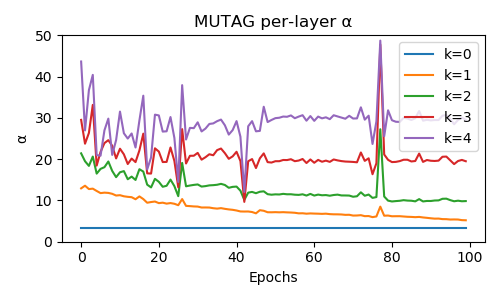

In [181]:
import matplotlib.pyplot as plt
%matplotlib notebook

for dataset in ['MUTAG']:
    epoch_k_alphas = defaultdict(list)
    for epoch in range(1, args['epochs'] + 1):
        for k in range(5):
            l = []
            for fold in range(10)[:1]:
                l.append(dataset_fold_epoch_k_alphas[(dataset, fold, epoch, k)])
            epoch_k_alphas[(k, 'mean')].append(np.mean(l))
            epoch_k_alphas[(k, 'std')].append(np.std(l))
    
    fig = plt.figure()
    fig.set_size_inches(5, 3)
    ax = fig.add_subplot(111)
    maxes = []
    for k in range(5):
        maxes.append(np.max(epoch_k_alphas[(k, 'mean')]))
        
    for k in range(5):
        means = epoch_k_alphas[(k, 'mean')] 
        ax.plot(range(len(means)), 
                    means, 
                    label=f"k={k}")
    ax.legend()
    ax.set_ylim([0, 50])
    ax.set_title(f"{dataset} per-layer α")
    plt.xlabel("Epochs")
    plt.ylabel("α")
    
    plt.tight_layout()
    fig.savefig(f"{dataset}_perlayer.pdf")

<IPython.core.display.Javascript object>


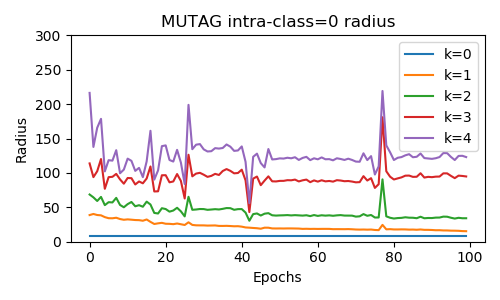

<IPython.core.display.Javascript object>


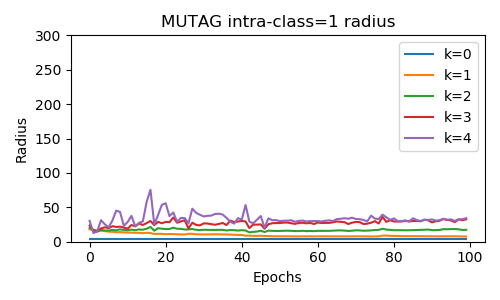

In [179]:
for dataset in ['MUTAG']:
    epoch_k_c_radii = defaultdict(list)
    for epoch in range(1, args['epochs'] + 1):
        for k in range(5):
            for c in [0, 1]:
                l = []
                for fold in range(10)[:1]:
                    l.append(dataset_fold_epoch_kc_radii[(dataset, fold, epoch, k, c)])
                epoch_k_c_radii[(k, c, 'mean')].append(np.mean(l))
    for c in [0, 1]:
        fig = plt.figure()
        fig.set_size_inches(5, 3)
        ax = fig.add_subplot(111)
        
        for k in range(5):
            # normalize to unit
            means = epoch_k_c_radii[(k, c, 'mean')] 
            ax.plot(range(len(means)), 
                        means, 
                        label=f"k={k}")
        ax.set_ylim([0, 300])
        
        ax.legend()
        ax.set_title(f"{dataset} intra-class={c} radius")
        
        plt.xlabel("Epochs")
        plt.ylabel("Radius")
        plt.tight_layout()
        fig.savefig(f"{dataset}_{c}_radius.pdf")

In [76]:
### DEBUG

graphs = test_graphs
minibatch_size = args['batch_size']

model.eval()
output = []
idx = np.arange(len(graphs))
k_c_radii = defaultdict(list)
k_alphas = defaultdict(list)
print(f"{len(graphs)} graphs to do.")

for i in range(0, len(graphs), minibatch_size):
    sampled_idx = idx[i:i+minibatch_size]
    if len(sampled_idx) == 0:
        continue
    hiddens, pooleds = model.features([graphs[j] for j in sampled_idx])
    labels = torch.LongTensor([graphs[j].label for j in sampled_idx])
    
    for k, pooled in enumerate(pooleds[1:]):
        c_centroid = {}
        for c in [0, 1]:
            pooledc = pooled[(labels == c).nonzero().squeeze(1)]
            centroid = pooledc.mean(dim=0)
            c_centroid[c] = centroid.detach().cpu().numpy()
            inter_class_EDM = inter_batch_distance_vec(pooledc)
            inter_class_radius = inter_batch_radius(pooledc, centroid)
            k_c_radii[(k, c)].append(inter_class_radius.detach().cpu().numpy())
            print(inter_class_radius)
        
        intra_class_alpha = np.linalg.norm(c_centroid[0] - c_centroid[1]) / 2
        print(intra_class_alpha)
        k_alphas[k].append(intra_class_alpha)
        print()
        
for k in range(len(pooleds[1:])):
    print(f"{k}:\t{np.mean(k_alphas[k])}")

20 graphs to do.
tensor(7.7096, device='cuda:0')
tensor(4.3636, device='cuda:0')
3.3682258129119873

tensor(30.3129, device='cuda:0', grad_fn=<SelectBackward>)
tensor(12.0110, device='cuda:0', grad_fn=<SelectBackward>)
10.561640739440918

tensor(48.9179, device='cuda:0', grad_fn=<SelectBackward>)
tensor(9.2227, device='cuda:0', grad_fn=<SelectBackward>)
13.661537170410156

tensor(77.2667, device='cuda:0', grad_fn=<SelectBackward>)
tensor(7.9429, device='cuda:0', grad_fn=<SelectBackward>)
14.632969856262207

tensor(130.2473, device='cuda:0', grad_fn=<SelectBackward>)
tensor(3.1402, device='cuda:0', grad_fn=<SelectBackward>)
16.847034454345703

0:	3.3682258129119873
1:	10.561640739440918
2:	13.661537170410156
3:	14.632969856262207
4:	16.847034454345703
